# Sprint 9 Project: Machine Learning in Business

## Introduction

### Objective:
I work for the OilyGiant mining company. My task is to find the best (most profitable) location for a new oil well. 

### Workflow:
I have data for three geographical regions (A, B, and C) and will analyze it to determine the most profitable location as follows:
- Access and prepare the data
- Train and test a model for each region
    - Split into training and validation set
    - Train model and make predictions for validation set
    - Determine model RMSE and average volume of oil reserves
- Prepare profit calculation
    - Calcualte volume of oil reserves sufficient for developing a new well without losses
- Write a function to calculate profit based on model predictions
    - Select wells with highest predicted values
    - Determine target volume of oil reserves
    - Suggest region for development and justify choice
- Calculate risk and profit for each region
    - Use Bootstrap technique to find distribution of profit
    - Find average profit, 95% confidence interval, and risk of losses
    - Suggest region for development and justify choice
    
### Conditions:
- Only linear regression is suitable for model training
- When exploring each region, a study of 500 points was conducted and the best 200 will selected for development
- Budget for oil well development is 100 million USD
- One barrel of raw oil produces 4.50 USD revenue
- Only a risk tolerance of under 2.5% is acceptable
- Details of oil well locations and features are not disclosed and are masked in the data
    
## Import Libraries and Prepare Data    
    
### Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Access Data

In [2]:
# Access the data and read into dataframes - converting region names from 0/1/2 to A/B/C for readability
geo_data_A = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_B = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_C = pd.read_csv('/datasets/geo_data_2.csv')

### Inspect Data

In [3]:
# Inspect each dataframe
# Print info for each dataframe
print('Info:')
geo_data_A.info()
print()
geo_data_B.info()
print()
geo_data_C.info()
print()

# Print first 5 rows of each dataframe
print('Head:')
print(geo_data_A.head())
print()
print(geo_data_B.head())
print()
print(geo_data_C.head())
print()

# Check for missing values
print('Check for Missing Values')
print(geo_data_A.isna().sum())
print(geo_data_B.isna().sum())
print(geo_data_C.isna().sum())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print(len(geo_data_A[geo_data_A['id'].duplicated(keep=False)]['id'].unique()))
print(len(geo_data_B[geo_data_B['id'].duplicated(keep=False)]['id'].unique()))
print(len(geo_data_C[geo_data_C['id'].duplicated(keep=False)]['id'].unique()))
print()

# Check full data for duplicates
print(geo_data_A[geo_data_A['id'].duplicated(keep=False)].sort_values(by=['id']))
print(geo_data_B[geo_data_B['id'].duplicated(keep=False)].sort_values(by=['id']))
print(geo_data_C[geo_data_C['id'].duplicated(keep=False)].sort_values(by=['id']))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   N

### Summary of Data

The data is split among three datasets, labeled 0, 1, and 2, each corresponding to a geographical region of interest. There are  100,000 rows of data in each, with no missing values. The headings are defined below:
- id - unique oil well identifier
- f0, f1, f2 - features of oil well locations
- product - volume of reserves in the oil well (thousand barrels)

The data types all appear correct:
- id is an alphanumeric string corresponding to oil well locations, so object is appropriate
- f0, f1, and f2 are unlabeled but significant features of oil well locations in a float format
- product is volume of oil reserves as a float

There are a few duplicated oil well ID's (10, 4, and 4, respectively) that should be removed entirely, since there is conflicting data between each duplicate and it is not possible to determine which of the two is correct.

### Correcting Data

In [4]:
# Removing duplicate oil well IDs entirely
geo_data_A.drop_duplicates(subset=['id'], keep=False, inplace=True)
geo_data_B.drop_duplicates(subset=['id'], keep=False, inplace=True)
geo_data_C.drop_duplicates(subset=['id'], keep=False, inplace=True)

# Confirming removal of duplicates
geo_data_A.info()
geo_data_B.info()
geo_data_C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
--

## Model Training and Testing

### Split Data into Training and Validation Sets, Features vs. Target

In [5]:
# Splitting each dataframe into training and validation sets (75:25)

geo_data_A_train, geo_data_A_valid = train_test_split(geo_data_A, test_size=0.25, random_state=12345)
geo_data_B_train, geo_data_B_valid = train_test_split(geo_data_B, test_size=0.25, random_state=12345)
geo_data_C_train, geo_data_C_valid = train_test_split(geo_data_C, test_size=0.25, random_state=12345)

# Features are f0, f1, and f2. Target is product. ID is not relevant to the model.
# Creating training sets

geo_data_A_train_features = geo_data_A_train.drop(['id', 'product'], axis=1)
geo_data_A_train_target = geo_data_A_train['product']

geo_data_B_train_features = geo_data_B_train.drop(['id', 'product'], axis=1)
geo_data_B_train_target = geo_data_B_train['product']

geo_data_C_train_features = geo_data_C_train.drop(['id', 'product'], axis=1)
geo_data_C_train_target = geo_data_C_train['product']

# Doing the same for validation sets

geo_data_A_valid_features = geo_data_A_valid.drop(['id', 'product'], axis=1)
geo_data_A_valid_target = geo_data_A_valid['product']

geo_data_B_valid_features = geo_data_B_valid.drop(['id', 'product'], axis=1)
geo_data_B_valid_target = geo_data_B_valid['product']

geo_data_C_valid_features = geo_data_C_valid.drop(['id', 'product'], axis=1)
geo_data_C_valid_target = geo_data_C_valid['product']

### Train Model

For this project, I am using a Linear Regression model.

In [6]:
# Training Linear Regression model using training datasets
# Define the type of model
modelA = LinearRegression()
modelB = LinearRegression()
modelC = LinearRegression()

# Fit the model into each set of training features and target data
modelA.fit(geo_data_A_train_features, geo_data_A_train_target)
modelB.fit(geo_data_B_train_features, geo_data_B_train_target)
modelC.fit(geo_data_C_train_features, geo_data_C_train_target)

# Making predictions about each validation dataset
predictions_valid_A = modelA.predict(geo_data_A_valid_features)
predictions_valid_B = modelB.predict(geo_data_B_valid_features)
predictions_valid_C = modelC.predict(geo_data_C_valid_features)

# Print results
print(f'Prediction for Region A: {predictions_valid_A}')
print()
print(f'Prediction for Region B: {predictions_valid_B}')
print()
print(f'Prediction for Region C: {predictions_valid_C}')

Prediction for Region A: [ 62.28661337  70.42817752  87.34956247 ...  95.05743312  78.94454642
 115.48299868]

Prediction for Region B: [ 55.97173467  54.63363312  54.67483347 ... 110.00204638 137.90166257
   0.51133538]

Prediction for Region C: [ 42.98902811  95.46229171 109.40809048 ...  85.50757813 111.31955742
  75.94431003]


### Average Predicted Oil Reserves and Model RMSE

In [7]:
# Average predicted oil reserves will be the average of all values in predict0, predict1, and predict2
print(f'Average predicted oil reserves in Region A: {predictions_valid_A.mean():.2f}')
print()
print(f'Average predicted oil reserves in Region B: {predictions_valid_B.mean():.2f}')
print()
print(f'Average predicted oil reserves in Region C: {predictions_valid_C.mean():.2f}')
print()
print()

# RMSE is square root of MSE
rmseA = mean_squared_error(geo_data_A_valid_target, predictions_valid_A) ** 0.5
rmseB = mean_squared_error(geo_data_B_valid_target, predictions_valid_B) ** 0.5
rmseC = mean_squared_error(geo_data_C_valid_target, predictions_valid_C) ** 0.5

# Print RMSEs
print(f'RMSE of model for Region A: {rmseA:.2f}')
print()
print(f'RMSE of model for Region B: {rmseB:.2f}')
print()
print(f'RMSE of model for Region C: {rmseC:.2f}')

Average predicted oil reserves in Region A: 92.42

Average predicted oil reserves in Region B: 68.98

Average predicted oil reserves in Region C: 95.12


RMSE of model for Region A: 37.72

RMSE of model for Region B: 0.89

RMSE of model for Region C: 39.98


### Analysis of Model Predictions

The model predicts lowest average oil reserves in Region B (x̄ = 68.98 thousand barrels), followed by Region A (x̄ = 92.42 thousand barrels), and Region C (x̄ = 95.12 thousand barrels). However, the root mean squared error (RMSE) of the model for Region B is also lowest (0.89), followed by Region A (37.72), and Region C (39.98). The results are summarized in the table below:

| Region | Predicted Reserves (x1000 Barrels) | RMSE |
|:----------:|:----------:|:----------:|
| A  | 92.42  | 37.72 |
| B  | 68.98  | 0.89 |
| C  | 95.12  | 39.98 |

While Region B is predicted to have the lowest oil reserves, its model also has the lowest RMSE. It would be premature to assume that any region is the most likely to be profitable from just this analysis, so further investigation is required.

## Profit Calculation

### Preparing Variables

In [8]:
# Defining variables for profit calculation
# Create variable for budget
budget_amount = 100000000

# Create variable for well sample size
well_sample_size = 200

# Create variable for revenue per unit of product (1000 barrels of oil)
revenue_per_unit = 4500

Calculation for minimum average oil volume per well to break even on investment:

*(Total Budget / Revenue Per Well) / Number of Wells = Minimum Average Volume Per Well*

### Calculating Minimum Reserves to Avoid Losses

In [9]:
# Calculate minimum volume per well  
average_volume_per_well = (budget_amount / revenue_per_unit) / well_sample_size

# Print result
print(f'The minimum volume of oil each well would need to produce to break even is: {average_volume_per_well:.2f}')

# Caculate the average oil volume per well for each region 
region_A_average = geo_data_A['product'].mean()
region_B_average = geo_data_B['product'].mean()
region_C_average = geo_data_C['product'].mean()

# Print average volumes for each region
print(f'On average, the volume of oil each well in Region A produces is: {region_A_average:.2f}')
print(f'On average, the volume of oil each well in Region B produces is: {region_B_average:.2f}')
print(f'On average, the volume of oil each well in Region C produces is: {region_C_average:.2f}')

The minimum volume of oil each well would need to produce to break even is: 111.11
On average, the volume of oil each well in Region A produces is: 92.50
On average, the volume of oil each well in Region B produces is: 68.82
On average, the volume of oil each well in Region C produces is: 95.00


### Summary of Profitability

Compared to the minimum break-even volume of 111.11, Regions A (92.50), B (68.82), and C (95.00), on average, produce a lot less oil. Investing at this point would not be profitable. I will have to do further analysis before determining the best region in which to invest.

## Calculate Profit From Set of Selected Oil Wells & Model Predictions

### Writing a Function to Calculate Profit

In [10]:
# This version of function prints results but does not return profit (see below)
def calculate_profit(target, probabilities, count, budget, revenue, region, printing=True):
    # Convert target and probabilities into series
    target_series = pd.Series(target)
    predictions_series = pd.Series(probabilities)
        
    # Reset the index on the target
    target_series = target_series.reset_index(drop=True)
    predictions_series = predictions_series.reset_index(drop=True)
    
    # Sort the predictions by descending volume and select the indices of the top 200 oil producing wells
    # These indices will be used to filter for the actual values of those top 200 wells so that we can calculate revenue
    top_wells = predictions_series.sort_values(ascending=False).head(count).index
    
    # Get the total volume of oil from the top 200 wells 
    actual_volume = target_series.loc[top_wells].sum()
    
    # Get the average volume of oil from the top 200 wells 
    average_volume = target_series.loc[top_wells].mean()
    
    # Calcuate revenue
    # Revenue is the volume of oil for top 200 wells multiplied by $4500
    revenue_calc = actual_volume * revenue_per_unit
    
    # Profit is defined as the revenue minus our budget of $100 Million USD to purchase 200 wells in a region
    profit = revenue_calc - budget
    
    # Print values if printing=True
    if printing:
        print(region)
        print('The total oil reserve size for', region, 'is', round(actual_volume, 2))
        print('The average volume per the top 200 wells in', region, 'is', round(average_volume, 2))
        print('The revenue for', region, 'is', round(revenue_calc, 2))
        print('The profit for', region, 'is', round(profit, 2))
        print()
    
    return profit
         
# Call function to calculate revenue and profit per region and other metrics per region    
calculate_profit(geo_data_A_valid_target, predictions_valid_A, well_sample_size, budget_amount, revenue_per_unit, 'Region A')
calculate_profit(geo_data_B_valid_target, predictions_valid_B, well_sample_size, budget_amount, revenue_per_unit, 'Region B')
calculate_profit(geo_data_C_valid_target, predictions_valid_C, well_sample_size, budget_amount, revenue_per_unit, 'Region C')

Region A
The total oil reserve size for Region A is 29191.17
The average volume per the top 200 wells in Region A is 145.96
The revenue for Region A is 131360260.57
The profit for Region A is 31360260.57

Region B
The total oil reserve size for Region B is 27589.08
The average volume per the top 200 wells in Region B is 137.95
The revenue for Region B is 124150866.97
The profit for Region B is 24150866.97

Region C
The total oil reserve size for Region C is 27702.1
The average volume per the top 200 wells in Region C is 138.51
The revenue for Region C is 124659457.92
The profit for Region C is 24659457.92



24659457.92012264

### Summary of Profitability of Each Region

In the previous step, I created a function to perform the following steps:
1. Using the model's predicted volume for each oil well in region, I created a list of the top 200 wells in each region.
2. Using the incidices of these 200 wells, I selected the actual volume of these wells from the target validation set.
3. Using the actual volume of the top 200 wells in each region, I summed the volume of each well to get a total volume for the region.
4. I then multiplied the total volume by 4500 which is the price per 1000 barrels (one unit of volume). This provides the revenue for the top 200 wells in each region.
5. If we subtract our budget of 100 Million USD from each region's revenue, we will know the profit the region is expected to make us if we invest in the creation of 200 wells in that region.

Overall, the region with the highest expected profit is Region C, providing a profit of 24,659,457.92. Findings are summarized in the table below:

| Region | Total Oil Reserves (x1000 Barrels) | Average Oil Reserves per Well (x1000 Barrels) | Revenue (USD) | Profit (USD) |
|:----------:|:----------:|:----------:|:----------:|:----------:|
| A  | 27525.41 | 137.63 | 123,864,348.34  | 23,864,348.34 |
| B  | 27137.65  | 135.69 | 122,119,420.42  | 22,119,420.42  |
| C  | 27702.10  | 138.51 | 124,659,457.92  | 24,659,457.92  |  

Additionally, recall that to break even, we needed an average volume of 111.11. When we pick the top 200 wells in each region, we see that the volume far exceeds 111.11. There is a chance now that we can be profitable, but we will need to calculate the risk of having losses in each region, which will be calculated in a later step.

## Calculate Risks and Profit for Each Region

### Using Bootstrap Technique to Find Distribution of Profit

### Find Average Profit, 95\% Confidence Interval & Risk of Losses

Loss means negative profit, so risk of loss is the probability that the profit is negative, expressed as a percentage.

Region A
The lower and upper bounds of the 95% confidence interval are [-368420.83, 9017043.58]
The average profit of Region A is 4378754.96
The risk of losses is 3.7 % - This is the probability that profit will be negative

Region B
The lower and upper bounds of the 95% confidence interval are [638552.54, 8471097.63]
The average profit of Region B is 4589741.58
The risk of losses is 1.2 % - This is the probability that profit will be negative

Region C
The lower and upper bounds of the 95% confidence interval are [-1936033.38, 8460845.15]
The average profit of Region C is 3184010.0
The risk of losses is 13.5 % - This is the probability that profit will be negative



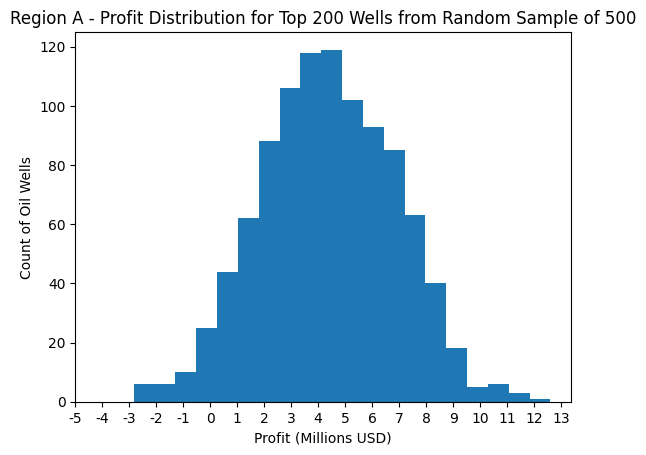

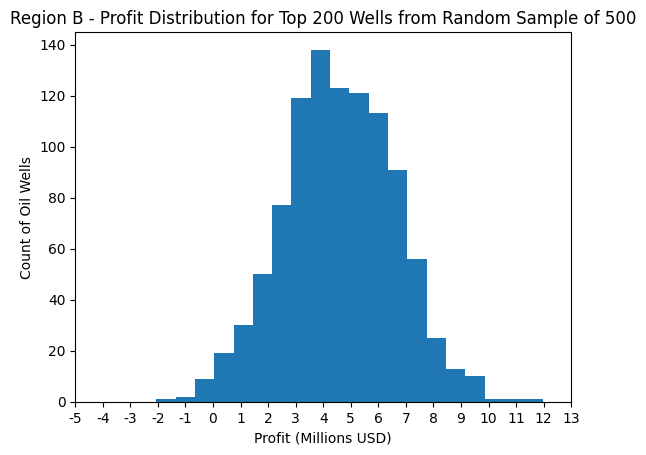

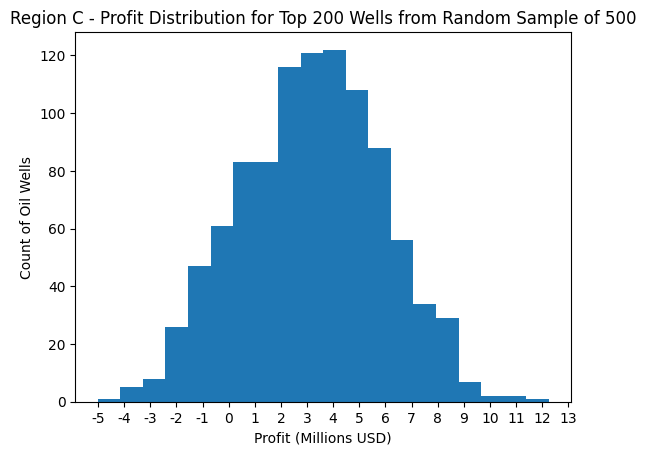

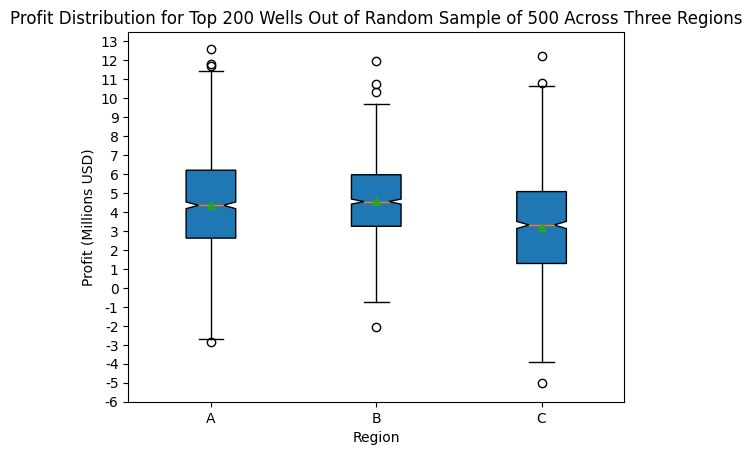

In [42]:
# Create a function for bootstrapping for confidence intervals 
# Parameterswill be the same as for the profit function
def calculate_profit_bootstrap(target, probabilities, count, budget, revenue, region):
    
    # Convert target and probabilities into series
    target_series = pd.Series(target)
    predictions_series = pd.Series(probabilities)
    
    # Reset the index on the target and predictions
    target_series = target_series.reset_index(drop=True)
    predictions_series = predictions_series.reset_index(drop=True)
       
    # Create a list to store profits of each region 
    values = []
        
    # We run the profit calculation 1000 times using a sample of 200 wells from each region
    # This will allow us to determine the average profit of any n number of wells to calculate loss
    for i in range(1000):
        target_subsample = target_series.sample(n=500, replace=True)
        probs_subsample = predictions_series[target_subsample.index]
        # Append profit of each subsample to values list, with profit function printing disabled
        values.append(calculate_profit(target_subsample, probs_subsample, count, budget, revenue, region, printing=False))
    
    # Convert values to a series
    values = pd.Series(values)
    
    # Create a upper and lower bound to calculate 95% confidence interval (2.50% - 97.5%)
    lower = round(values.quantile(0.025), 2)
    upper = round(values.quantile(0.975), 2)
    
    # Calculate mean of sample
    mean = values.mean()
    
    # We want to determine how many of the 1000 runs have negative profit to calculate risk of loss percentage
    # unprofitable wells on average / 1000 runs of the function
    risk_of_losses = (values < 0).mean() * 100   
   
    # Print metrics about the bootstrapping
    print(region)
    print('The lower and upper bounds of the 95% confidence interval are', list((lower, upper)))
    print('The average profit of', region,'is', round(mean, 2))
    print('The risk of losses is', round(risk_of_losses, 2),'% - This is the probability that profit will be negative')
    print()
    
    # Return values divided by 10 to change units to USD millions
    return values

# Create empty lists to store profit values sorted by region in for plotting later
region_A_values = []
region_B_values = []
region_C_values = []

# Append profit values into empty lists per region
region_A_values.append(calculate_profit_bootstrap(geo_data_A_valid_target, predictions_valid_A, well_sample_size, budget_amount, revenue_per_unit, 'Region A'))
region_B_values.append(calculate_profit_bootstrap(geo_data_B_valid_target, predictions_valid_B, well_sample_size, budget_amount, revenue_per_unit, 'Region B'))
region_C_values.append(calculate_profit_bootstrap(geo_data_C_valid_target, predictions_valid_C, well_sample_size, budget_amount, revenue_per_unit, 'Region C'))

# Plot distributions of profit from sampling the top 200 wells in each region from results above 
# Region A
plt.hist(region_A_values, bins=20)
plt.title('Region A - Profit Distribution for Top 200 Wells from Random Sample of 500')
plt.xlabel('Profit (Millions USD)')
plt.ylabel('Count of Oil Wells')
plt.xticks([-5000000, -4000000, -3000000, -2000000, -1000000, 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000], ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
plt.show()

# Region B
plt.hist(region_B_values, bins=20)
plt.title('Region B - Profit Distribution for Top 200 Wells from Random Sample of 500')
plt.xlabel('Profit (Millions USD)')
plt.ylabel('Count of Oil Wells')
plt.xticks([-5000000, -4000000, -3000000, -2000000, -1000000, 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000], ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
plt.show()

# Region C
plt.hist(region_C_values, bins=20)
plt.title('Region C - Profit Distribution for Top 200 Wells from Random Sample of 500')
plt.xlabel('Profit (Millions USD)')
plt.ylabel('Count of Oil Wells')
plt.xticks([-5000000, -4000000, -3000000, -2000000, -1000000, 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000], ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
plt.show()

# Create a boxplot of all 3 regions' profit distributions
# Making sure all data is in list format for boxplot
region_A_values = np.array(region_A_values)
region_B_values = np.array(region_B_values)
region_C_values = np.array(region_C_values)
# Creating a list of lists to plot boxplot
boxplot_data = [region_A_values, region_B_values, region_C_values]
# Data had shape 1,1000 instead of 1000,1 so it needed to be flattened
boxplot_data = [d.flatten() for d in boxplot_data]
# Plot the boxplot   
categories = ['A', 'B', 'C']
plt.boxplot(boxplot_data, labels=categories, notch=True, patch_artist=True, showmeans=True)
plt.title('Profit Distribution for Top 200 Wells Out of Random Sample of 500 Across Three Regions')
plt.xlabel('Region')
plt.ylabel('Profit (Millions USD)')
plt.yticks([-6000000, -5000000, -4000000, -3000000, -2000000, -1000000, 0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000], ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
plt.show()

As shown in the histograms above, the distributions for each region look to be normally distributed around the average profit for the region. In addition, the average profit for each region occurs with a variable number of oil wells. The average profits and numbers of wells look to be around the following representative estimates:

- Region A - \$4 Million from 120 wells
- Region B - \$5 Million from 120 wells
- Region C - \$3 Million from 130 wells

*(Note: the exact results change each time the experiment is run)*

## Findings and Conclusion

### Findings

Representative findings are summarized in the table below *(Note: the exact results change each time the experiment is run)*:

| Region | Lower Bound (95% CI) (M USD) | Upper Bound (95% CI) (M USD)| Average Profit (M USD) | Risk of Losses (%) |
|:----------:|:----------:|:----------:|:----------:|:----------:|
| A  | -0.89 | 9.11 | 4.31 | 5.4 |
| B  | 0.87 | 8.56 | 4.81 | 1.0 |
| C  | -1.60 | 8.65 | 3.44  | 9.9  |  

### Conclusion

After my analysis, I suggest that OilyGiant mining company  develop new oil wells in **Region B**. 

This is due to strong results generated from using a bootstrapping technique. When we calculate profit for the top 200 wells from a random sample of 500 wells from each region, repeated 1000 times, we gain a more realistic understanding of what our profit or losses could be. By running the this experiment, we see that Region B not only has the highest average profit (\$4.81M), it also has the highest chance of being profitable (only 1.00\% risk of losses). 

Further, with a risk tolerance of only 2.5%, only Region B satisfies that requirement (1.0%). Region A (5.4%) and Region C (9.9%) have too great a risk of loss to be tolerated.

Finally, when inspecting the 95% confidence intervals of all three regions, Region B often doesn't have a negative profit in its lower bound (2.5% confidence interval), whereas Regions A and C typically do.

After running my analysis, **Region B** seems like both a safe and profitable selection for OilyGiant mining company to develop wells in.